In [62]:
import numpy as np
import math
import heapq

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import matplotlib.pyplot as plt
from a_star import *
import pickle
from shapely.geometry import Polygon, LineString
from shapely.geometry import Point
from magic import ordinator
import cv2
from scipy import ndimage

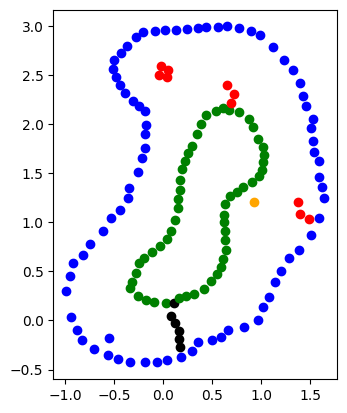

In [63]:
with open("SLAM20240131_094641.pickle", 'rb') as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:
# with open(r"SLAM20240121_162038.pickle", "rb") as input_file:
# with open(r"SLAM20240124_162059.pickle", "rb") as input_file:

    e = pickle.load(input_file)

positions = e['positions']
ids = e['ids']
ids = np.array(ids)
robot_pose=e['robot_pose']

for i, pos_zip in enumerate(zip(positions, ids)):
    col = pos_zip[1] % 3
    if col == 0:
        col2 = 'green'
    elif col == 1:
        col2 = 'red'
    elif col == 2:
        col2 = 'blue'
    if pos_zip[1] < 100:
        col2 = 'black'
    plt.scatter(*pos_zip[0], color=col2)

plt.scatter(*robot_pose, color='orange')
# plt.scatter(0, 0, color='orange', marker='3',)
plt.gca().set_aspect('equal')
plt.show()


positions_array = np.array(positions)

mask_external = (ids % 3 == 2) & (ids >= 100) & (ids <= 1000)
mask_internal = (ids % 3 == 0) & (ids >= 100) & (ids <= 1000)
mask_obstacle = (ids % 3 == 1) & (ids >= 100) & (ids <= 1000)
mask_start_line = (ids < 100)


ids_external = ids[mask_external]
ids_internal = ids[mask_internal]

positions_external = positions_array[mask_external]
positions_internal = positions_array[mask_internal]
positions_obstacle = positions_array[mask_obstacle]
positions_start_line = positions_array[mask_start_line]

Missing 1 nodes to close the polygon; min_dist = 1.0516905158879852


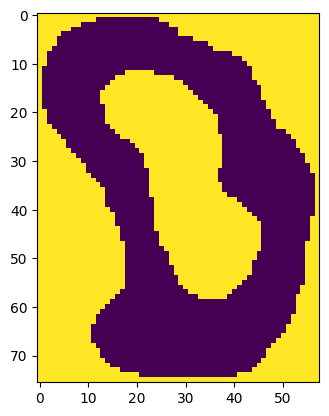

In [64]:
pos_list_ext = [pos for pos in positions_external]
pos_list_int = [pos for pos in positions_internal]

external_ordered = np.array(ordinator(pos_list_ext, max_distance=0.6))
internal_ordered = np.array(ordinator(pos_list_int))

spatial_step = 0.03
max_x = np.max(external_ordered[:, 0])
max_y = np.max(external_ordered[:, 1])
min_x = np.min(external_ordered[:, 0])
min_y = np.min(external_ordered[:, 1])
delta_x = max_x-min_x
delta_y = max_y-min_y
center_x = min_x+delta_x/2
center_y = min_y+delta_y/2

n_x = int(delta_x/spatial_step/1.5)
n_y = int(delta_y/spatial_step/1.5)

ext_ordered_poly = Polygon(external_ordered)
int_ordered_poly = Polygon(internal_ordered)


x = np.linspace(min(np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), max(
    np.concatenate([external_ordered[:, 0], internal_ordered[:, 0]])), n_x)
y = np.linspace(min(np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), max(
    np.concatenate([external_ordered[:, 1], internal_ordered[:, 1]])), n_y)
X, Y = np.meshgrid(x, y)

# Create a mask where the pixels inside the first circle and outside the second circle are set to 1, and all others are set to 0
mask_internal = np.array([[int_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])
mask_external = np.array([[not ext_ordered_poly.contains(
    Point(x[i], y[j])) for i in range(len(x))] for j in range(len(y))])

mask_internal=ndimage.binary_dilation(mask_internal, iterations=2)
# mask_internal=1-mask_tmp
mask=mask_internal+ mask_external
plt.imshow(mask)

In [65]:
mask_line_obs=np.zeros_like(mask, dtype=bool)
for x_i,y_i in np.vstack((positions_start_line, positions_obstacle)):
    mask_line_obs += np.array([[Point(x_i,y_i).buffer(0.1).contains(Point(x[i], y[j]))
                for i in range(len(x))] for j in range(len(y))])

In [66]:
# from numba import jit
# import numpy as np

# @jit(nopython=True)
# def contains_points(x, y, positions):
#     result = np.zeros_like(x, dtype=bool)
#     for pos in positions:
#         result |= (x - pos[0])**2 + (y - pos[1])**2 <= 0.1**2
#     return result

# mask_line_obs = contains_points(x, y, np.vstack((positions_start_line, positions_obstacle)))


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function zeros_like at 0x7f801298a0>) found for signature:
 
 >>> zeros_like(array(float64, 1d, C), dtype=Function(<class 'bool'>))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'ol_np_zeros_like': File: numba/np/arrayobj.py: Line 4444.
    With argument(s): '(array(float64, 1d, C), dtype=Function(<class 'bool'>))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<built-in function empty_like>) found for signature:
    
    >>> empty_like(array(float64, 1d, C), dtype=Function(<class 'bool'>))
    
   There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Overload in function 'ol_np_empty_like': File: numba/np/arrayobj.py: Line 4389.
           With argument(s): '(array(float64, 1d, C), dtype=Function(<class 'bool'>))':
          Rejected as the implementation raised a specific error:
            TypingError: Cannot parse input types to function np.empty_like(array(float64, 1d, C), Function(<class 'bool'>))
     raised from /home/pi/.ev3-venv/lib/python3.11/site-packages/numba/np/arrayobj.py:4407
   
   During: resolving callee type: Function(<built-in function empty_like>)
   During: typing of call at /home/pi/.ev3-venv/lib/python3.11/site-packages/numba/np/arrayobj.py (4450)
   
   
   File "../../../.ev3-venv/lib/python3.11/site-packages/numba/np/arrayobj.py", line 4450:
       def impl(a, dtype=None):
           arr = np.empty_like(a, dtype=dtype)
           ^

  raised from /home/pi/.ev3-venv/lib/python3.11/site-packages/numba/core/typeinfer.py:1086

During: resolving callee type: Function(<function zeros_like at 0x7f801298a0>)
During: typing of call at /tmp/ipykernel_3196/1828436246.py (6)


File "../../../../../tmp/ipykernel_3196/1828436246.py", line 6:
<source missing, REPL/exec in use?>


In [ ]:
mask=mask+mask_line_obs

In [ ]:
plt.imshow(mask, origin='lower')
plt.scatter(30,10)
plt.scatter(20,10)

In [ ]:
maze_plot(mask, (30,10),(20,10))